### Decrição do problema

A Dim Dim obtêm uma de suas receitas a partir de empréstimos. Mas muitas vezes o emprestimo está associado a um risco. 

O solicitante pode inadimplir o empréstimo e gerar prejuízo. Para mitigar esse problema, foi solicitado o uso de Machine Learning que pretende reduzir os impactos financeiros a partir de empréstimos.

## Dicinário dos dados

* ID = ID do cliente do requerente
* year = Ano de aplicação
* loan limit = montante máximo disponível do empréstimo que pode ser tomado
* Gender = tipo de sexo
* approv_in_adv = O empréstimo é pré-aprovado ou não
* loan_type = Tipo de empréstimo
* loan_purpose = a razão pela qual você quer pedir dinheiro emprestado
* Credit_Worthiness = Como um credor determina que você será inadimplente em suas obrigações de dívida ou como você merece receber um novo crédito.
* open_credit = É um empréstimo pré-aprovado entre um credor e um mutuário. Ele permite que o mutuário faça saques repetidos até um certo limite.
* business_or_commercial = Tipo de uso do valor do empréstimo
* loan_amount = O valor exato do empréstimo
* rate_of_interest = É o valor que um credor cobra de um mutuário e é uma porcentagem do principal - o valor emprestado.
* Interest_rate_spread = A diferença entre a taxa de juros que uma instituição financeira paga aos depositantes e a taxa de juros que recebe de empréstimos
* Upfront_charges = Taxa paga a um credor por um mutuário como contrapartida por fazer um novo empréstimo
* term = O período de amortização do empréstimo
* Neg_ammortization = Refere-se a uma situação em que um tomador de empréstimo faz um pagamento menor do que a parcela padrão definida pelo banco.
* interest_only = Quantidade de juros apenas sem princípios
* lump_sum_payment = É uma quantia de dinheiro que é paga em um único pagamento em vez de ser em parcelas.
* property_value = o valor presente dos benefícios futuros decorrentes da propriedade
* construction_type = Tipo de construção colateral
* occupancy_type = Classificações referem-se a estruturas de categorização com base em seu uso
* Secured_by = Tipo de Garantia segura
* total_units = número de unidades
* income = Refere-se à quantidade de dinheiro, propriedade e outras transferências de valor recebidas durante um determinado período de tempo
* credit_type = Tipo de crédito
* co-applicant_credit_type = É uma pessoa adicional envolvida no processo de solicitação de empréstimo. Tanto o requerente quanto o co-requerente solicitam e assinam o empréstimo
* age = idade do requerente
* submission_of_application = Verifica se a aplicação está completa ou não
* LTV = o valor do tempo de vida é um prognóstico do lucro líquido
* Region = Local do requerente
* Security_Type = Tipo de Garantia
* status = Status do empréstimo (aprovado/recusado)
* dtir1 = Relação dívida/renda

In [1]:
!pip install pyjanitor==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Autenticação GCP
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
#@title Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from google.cloud import bigquery
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
#@title Tamanho da figura 
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.3)

In [5]:
#@title Id do projeto e localização dos dados.
PROJECT = 'fiap2-368122' #@param {type:"string"}
LOCATION = 'US' #@param {type:"string"}

In [6]:
#@title Configuração para leitura dos dados
client = bigquery.Client(project=PROJECT, location=LOCATION)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## ID do Job no bigquery

Para obter esses dados você precisa obter o id de execução desta maneira:

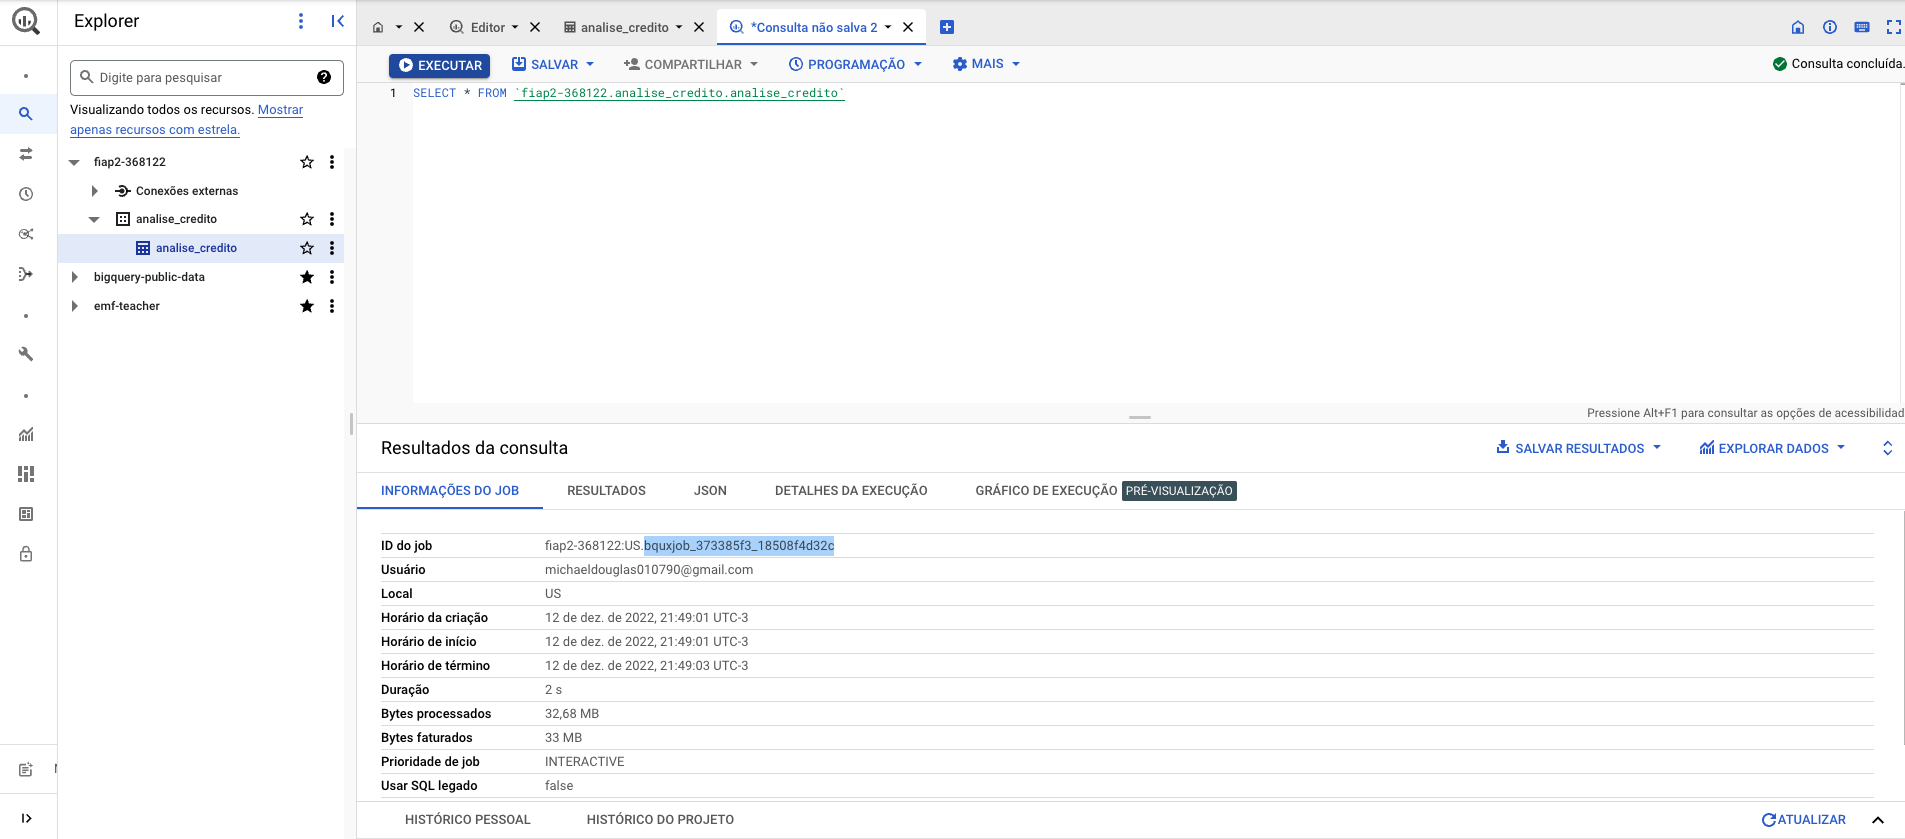

In [7]:
#Inserir o id do job como parâmetro
JOBID = 'bquxjob_291eb4a5_185120040ba' #@param {type:"string"}

In [8]:
job = client.get_job(JOBID)
job.query

'SELECT * FROM `fiap2-368122.analise_credito.analise_credito`'

In [9]:
job = client.get_job(JOBID)
result = job.to_dataframe()

### Outra forma de uso

Podemos também baixar o resultado e utilizar no Colab.

In [10]:
#@title Cópia de segurança do dataframe
# df = result
df=pd.read_csv('/content/loan_Default.csv')

In [11]:
#@title Dataframe dos dados
df.head(5)

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [12]:
#@title Dimensionalidade dos dados - Linhas/Colunas
df.shape

(148670, 34)

In [13]:
#@title Colunas do dataframe
df.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [14]:
#@title Conversão das colunas para minúsculas 
df.columns= df.columns.str.lower()

In [15]:
df.columns

Index(['id', 'year', 'loan_limit', 'gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'credit_worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'interest_rate_spread', 'upfront_charges', 'term', 'neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'income', 'credit_type', 'credit_score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'ltv', 'region', 'security_type',
       'status', 'dtir1'],
      dtype='object')

### Remoção de colunas

Removemos algumas colunas que não apresentavam necessidade para o nosso mobelo.


In [16]:
columns= ['id', 'year', 'loan_limit', 'gender', 'approv_in_adv','loan_purpose', 'credit_worthiness', 'open_credit','business_or_commercial','interest_rate_spread', 'upfront_charges', 'neg_ammortization','interest_only', 'lump_sum_payment','construction_type', 'occupancy_type', 'secured_by', 'total_units','credit_type', 'co-applicant_credit_type','submission_of_application', 'ltv', 'region', 'security_type']
df.drop(columns,axis=1, inplace =True)

In [17]:
df.columns

Index(['loan_type', 'loan_amount', 'rate_of_interest', 'term',
       'property_value', 'income', 'credit_score', 'age', 'status', 'dtir1'],
      dtype='object')

In [18]:
df.shape

(148670, 10)

In [19]:
#@title Dados filtrados e prontos para uso

pd.set_option("display.max_columns", df.shape[-1]) 
df.head()

,loan_type,loan_amount,rate_of_interest,term,property_value,income,credit_score,age,status,dtir1
0,type1,116500,NaN,360.0,118000.0,1740.0,758,25-34,1,45.0
1,type2,206500,NaN,360.0,NaN,4980.0,552,55-64,1,NaN
2,type1,406500,4.56,360.0,508000.0,9480.0,834,35-44,0,46.0
3,type1,456500,4.25,360.0,658000.0,11880.0,587,45-54,0,42.0
4,type1,696500,4.00,360.0,758000.0,10440.0,602,25-34,0,39.0


### Verificação de dados nulos

Aqui nós vamos verificar os dados nulos do nosso modelo, além disso colocamos o resultado em um DataFrame para exibir o total encontrado X a proporção de valores nulos do nosso modelo.

In [20]:
df.isnull().mean(axis=1).loc[:10]

0     0.1
1     0.3
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.1
dtype: float64

In [21]:
df.isnull() # Aqui verificamos o total de null na base se existir
df.isnull().sum()/len(df) # Aqui obtemos a proporção de null se existir

# Criamos um novo DataFrame para verificar o total e a proporção de null na base
pd.DataFrame(zip(df.isnull().sum(),df.isnull().sum()/len(df)), columns=['Count', 'Proportion'], index=df.columns)

,Count,Proportion
loan_type,0,0.000000
loan_amount,0,0.000000
rate_of_interest,36439,0.245100
term,41,0.000276
property_value,15098,0.101554
income,9150,0.061546
credit_score,0,0.000000
age,200,0.001345
status,0,0.000000
dtir1,24121,0.162245


In [22]:
#@title validação de valores duplicados
df.duplicated().sum()

6

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.duplicated().sum()

0

In [25]:
df.shape

(148664, 10)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148664 entries, 0 to 148669
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_type         148664 non-null  object 
 1   loan_amount       148664 non-null  int64  
 2   rate_of_interest  112227 non-null  float64
 3   term              148623 non-null  float64
 4   property_value    133568 non-null  float64
 5   income            139518 non-null  float64
 6   credit_score      148664 non-null  int64  
 7   age               148464 non-null  object 
 8   status            148664 non-null  int64  
 9   dtir1             124549 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 12.5+ MB


### Análise valores nulos e duplicados

Resolvemos os dados duplicados e agora iremos resolver os dados faltantes.

In [27]:
imputer = SimpleImputer()
df[['rate_of_interest', 'term','property_value','income','dtir1']] = imputer.fit_transform(df[['rate_of_interest', 'term','property_value','income','dtir1']])

In [28]:
imputer = SimpleImputer(strategy='most_frequent')
df[['age']] = imputer.fit_transform(df[['age']])

In [29]:
df.isna().sum()

loan_type           0
loan_amount         0
rate_of_interest    0
term                0
property_value      0
income              0
credit_score        0
age                 0
status              0
dtir1               0
dtype: int64

In [30]:
df.describe().round(2)

,loan_amount,rate_of_interest,term,property_value,income,credit_score,status,dtir1
count,148664.00,148664.00,148664.00,148664.00,148664.00,148664.00,148664.00,148664.00
mean,331119.68,4.05,335.14,497900.20,6957.39,699.79,0.25,37.73
std,183910.81,0.49,58.40,341173.91,6293.59,115.88,0.43,9.65
min,16500.00,0.00,96.00,8000.00,0.00,500.00,0.00,5.00
25%,196500.00,3.75,360.00,288000.00,3840.00,599.00,0.00,33.00
50%,296500.00,4.05,360.00,458000.00,6000.00,699.00,0.00,37.73
75%,436500.00,4.25,360.00,598000.00,8280.00,800.00,0.00,44.00
max,3576500.00,8.00,360.00,16508000.00,578580.00,900.00,1.00,61.00


In [31]:
df.dtypes

loan_type            object
loan_amount           int64
rate_of_interest    float64
term                float64
property_value      float64
income              float64
credit_score          int64
age                  object
status                int64
dtir1               float64
dtype: object

In [32]:
df['age'].value_counts(dropna=False)

45-54    34919
35-44    32815
55-64    32533
65-74    20744
25-34    19141
>74       7175
<25       1337
Name: age, dtype: int64

Reparemos aqui que existe algumas variáveis categoricas e isso pode ser ruim para o nosso modelo. Por este motivo criaremos variáveis dummies para essas colunas e assim transformaremos elas em númericas.

In [33]:
df = pd.get_dummies(df, columns=['loan_type','age'], drop_first=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148664 entries, 0 to 148669
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_amount       148664 non-null  int64  
 1   rate_of_interest  148664 non-null  float64
 2   term              148664 non-null  float64
 3   property_value    148664 non-null  float64
 4   income            148664 non-null  float64
 5   credit_score      148664 non-null  int64  
 6   status            148664 non-null  int64  
 7   dtir1             148664 non-null  float64
 8   loan_type_type2   148664 non-null  uint8  
 9   loan_type_type3   148664 non-null  uint8  
 10  age_35-44         148664 non-null  uint8  
 11  age_45-54         148664 non-null  uint8  
 12  age_55-64         148664 non-null  uint8  
 13  age_65-74         148664 non-null  uint8  
 14  age_<25           148664 non-null  uint8  
 15  age_>74           148664 non-null  uint8  
dtypes: float64(5), int64

In [35]:
pd.set_option("display.max_columns", df.shape[-1]) 
df.head()

,loan_amount,rate_of_interest,term,property_value,income,credit_score,status,dtir1,loan_type_type2,loan_type_type3,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74
0,116500,4.045482,360.0,118000.000000,1740.0,758,1,45.000000,0,0,0,0,0,0,0,0
1,206500,4.045482,360.0,497900.200647,4980.0,552,1,37.732932,1,0,0,0,1,0,0,0
2,406500,4.560000,360.0,508000.000000,9480.0,834,0,46.000000,0,0,1,0,0,0,0,0
3,456500,4.250000,360.0,658000.000000,11880.0,587,0,42.000000,0,0,0,1,0,0,0,0
4,696500,4.000000,360.0,758000.000000,10440.0,602,0,39.000000,0,0,0,0,0,0,0,0


In [36]:
df.shape

(148664, 16)

### Criação do DataFrame

Criaremos então um série (y) com os rótulos. Faremos isso para na sequência executar o treino e teste. Como a variável target que é estatus, sendo assim, nós a removeremos.

In [37]:
import janitor as jn

X, y = jn.ml.get_features_targets(df, target_columns="status")

#x = df.drop('status', axis=1)
#y = df['status']

In [38]:
X

,loan_amount,rate_of_interest,term,property_value,income,credit_score,dtir1,loan_type_type2,loan_type_type3,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74
0,116500,4.045482,360.0,118000.000000,1740.0,758,45.000000,0,0,0,0,0,0,0,0
1,206500,4.045482,360.0,497900.200647,4980.0,552,37.732932,1,0,0,0,1,0,0,0
2,406500,4.560000,360.0,508000.000000,9480.0,834,46.000000,0,0,1,0,0,0,0,0
3,456500,4.250000,360.0,658000.000000,11880.0,587,42.000000,0,0,0,1,0,0,0,0
4,696500,4.000000,360.0,758000.000000,10440.0,602,39.000000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,436500,3.125000,180.0,608000.000000,7860.0,659,48.000000,0,0,0,0,1,0,0,0
148666,586500,5.190000,360.0,788000.000000,7140.0,569,15.000000,0,0,0,0,0,0,0,0
148667,446500,3.125000,180.0,728000.000000,6900.0,702,49.000000,0,0,0,1,0,0,0,0
148668,196500,3.500000,180.0,278000.000000,7140.0,737,29.000000,0,0,0,0,1,0,0,0


In [39]:
y

0         1
1         1
2         0
3         0
4         0
         ..
148665    0
148666    0
148667    0
148668    0
148669    0
Name: status, Length: 148664, dtype: int64

In [40]:
X.shape

(148664, 15)

In [41]:
y.shape

(148664,)

### Separação da amostra

Usaremos o scikit-learn para extrair 30% dos dados para testes. Usamos random_state 42 para eliminar a aleatoriedade, pois queremos comprar diferentes modelos.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [43]:
X_train

,loan_amount,rate_of_interest,term,property_value,income,credit_score,dtir1,loan_type_type2,loan_type_type3,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74
96393,356500,3.990000,360.0,398000.0,9060.000000,748,33.000000,0,0,0,1,0,0,0,0
125680,256500,3.375000,180.0,318000.0,3120.000000,781,47.000000,0,0,0,0,0,0,0,0
143206,296500,4.125000,360.0,358000.0,5460.000000,754,47.000000,1,0,0,0,1,0,0,0
70180,426500,2.990000,360.0,458000.0,6957.392164,895,37.732932,0,1,0,1,0,0,0,0
26531,216500,3.500000,300.0,738000.0,3840.000000,600,48.000000,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76446,326500,3.875000,180.0,608000.0,7620.000000,753,33.000000,0,0,0,0,0,1,0,0
110835,356500,3.375000,360.0,708000.0,4440.000000,678,37.000000,0,0,1,0,0,0,0,0
21810,106500,4.500000,360.0,128000.0,2640.000000,761,37.000000,0,0,0,0,0,0,0,0
10591,426500,3.560000,360.0,628000.0,7740.000000,622,40.000000,0,0,0,1,0,0,0,0


In [44]:
X_train.shape

(104064, 15)

In [45]:
X_test

,loan_amount,rate_of_interest,term,property_value,income,credit_score,dtir1,loan_type_type2,loan_type_type3,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74
23151,296500,4.045482,360.0,4.080000e+05,4740.0,567,32.000000,0,0,0,0,0,1,0,0
57927,116500,4.500000,360.0,1.980000e+05,2940.0,724,30.000000,0,0,0,0,0,1,0,0
103698,306500,3.625000,360.0,3.880000e+05,6480.0,797,28.000000,0,0,0,0,0,0,0,0
8317,576500,3.500000,360.0,5.880000e+05,9000.0,563,39.000000,1,0,0,0,0,0,0,0
29427,136500,4.750000,360.0,1.680000e+05,2520.0,770,38.000000,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67033,746500,3.750000,360.0,1.188000e+06,20820.0,835,16.000000,0,0,1,0,0,0,0,0
74893,126500,3.990000,360.0,1.280000e+05,2100.0,804,38.000000,1,0,0,0,0,0,1,0
50603,606500,3.875000,360.0,7.680000e+05,12900.0,742,37.000000,0,0,1,0,0,0,0,0
140305,216500,4.045482,360.0,4.979002e+05,3480.0,625,37.732932,0,0,0,0,0,1,0,0


In [46]:
X_test.shape

(44600, 15)

In [47]:
y_train

96393     0
125680    0
143206    0
70180     0
26531     0
         ..
76446     0
110835    0
21810     0
10591     0
25820     1
Name: status, Length: 104064, dtype: int64

In [48]:
X_train.shape

(104064, 15)

In [49]:
y_train.shape

(104064,)

In [50]:
y_train.value_counts()

0    78369
1    25695
Name: status, dtype: int64

In [51]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [52]:
y_train.value_counts()

0    78369
1    78369
Name: status, dtype: int64

In [53]:
model=DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[33603    55]
 [   26 10916]]
0.9981838565022422


In [54]:
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


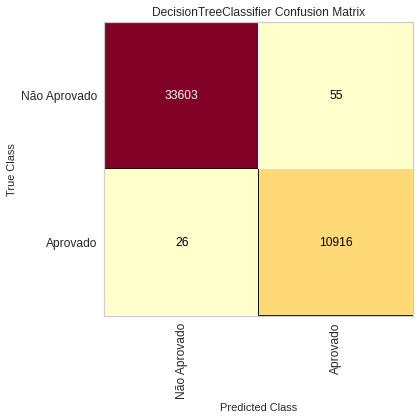

In [55]:
mapping = {0: "Não Aprovado", 1: "Aprovado"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    model,
    classes=["Não Aprovado", "Aprovado"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

In [56]:
from sklearn.metrics import (
    roc_auc_score
)

In [57]:
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

0.9979948753717479

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


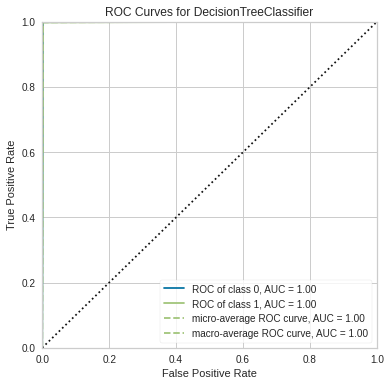

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(model)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()

In [59]:
from sklearn.model_selection import (
    StratifiedKFold
)
from yellowbrick.model_selection import (
    LearningCurve
)

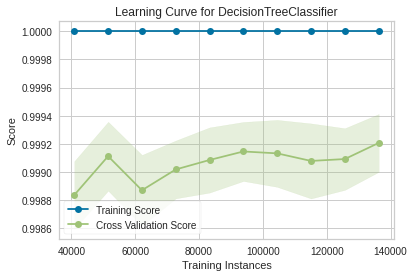

In [60]:
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    model,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X, y)
lc_viz.poof()

### Exportação do modelo

Decidimos exportar o modelo para ser utililzado posteriormente

In [61]:
import pickle

def dumpModel(model, filename):
  pickle.dump(model, open(filename, 'wb'))

In [62]:
X_test.columns

Index(['loan_amount', 'rate_of_interest', 'term', 'property_value', 'income',
       'credit_score', 'dtir1', 'loan_type_type2', 'loan_type_type3',
       'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'age_<25',
       'age_>74'],
      dtype='object')

In [63]:
filename = 'loan_decisiontreeclassifier.sav'

dumpModel(model, filename) # Aqui exportamos o nosso modelo para utilizar no Flask

### Teste do arquivo exportado

Fizemos um teste para garantir que está tudo correto com a execução do modelo

In [64]:
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X_test)

In [65]:
result = roc_auc_score(y_test, y_pred)

print(
    f'Pontuação do AUC: ' + \
    f'{result*100:.2f}'
)

Pontuação do AUC: 99.80
